<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/open_cv_remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw


def get_gradation_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T
def get_gradation_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=np.float)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = get_gradation_2d(start, stop, width, height, is_horizontal)
    return result

def nparray_to_rgb(nparry:np.array):
  return (int(nparry[0]),int(nparry[1]),int(nparry[2]))
  
def find_edge(img_path:str):
  img = cv2.imread(img_path,0)
  blur = cv2.blur(img,(5,5))
  edges = cv2.Canny(blur,100,200)
  return edges

def find_target(edges): 
  results = np.where(edges==250)
  top = np.min(results[0])
  bottom = np.max(results[0])
  left = np.min(results[1])
  right = np.max(results[1])
  return (left,top,right,bottom)

def to_RGB(image:Image):
  if image.mode == 'RGB': return image
  background = Image.new("RGB", image.size, (255, 255, 255))
  background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
  background.format = image.format
  return background

def open_rgb(image_path: str):
    im = Image.open(image_path)
    im = to_RGB(im)
    return im

def get_median_color(img:Image,px):
  array = np.array(img)
  median = np.median(array,axis=1)
  return median[px]

def get_around(img_path):
  edges = find_edge(img_path)
  left,top,right,bottom = find_target(edges)
  return (left,top,right,bottom)

def average_np(array:list):
  array = np.array(array)
  array = np.median(array,axis=0)
  return (int(array[0]),int(array[1]),int(array[2]))

def get_xy_center(around:list):
  x = around[0] + around[2]
  y = around[1] + around[3]
  return int(x/2),int(y/2)

def get_width(around:list):
  return around[2] - around[0]

def get_height(around:list):
  return around[3] - around[1]

def get_longer(around):
  longer = get_width(around)
  height = get_height(around)
  if longer < height:longer = height
  return longer

def make_background(top_color,bottom_color,img_size):
  print('top_color',top_color)
  print('bottom_color',bottom_color)

  bg_top_color = average_np(top_color)
  bg_bottom_color = average_np(bottom_color)
  bg_color = np.array([bg_top_color,bg_bottom_color])
  bg_color = np.median(bg_color,axis=0)
  bg_color = bg_color.astype('int')
  print('bg_top_color',bg_top_color)
  print('bg_bottom_color',bg_bottom_color)
  print('bg_color',bg_color)
  bg = Image.new('RGB', (img_size,img_size), tuple(bg_color))

#   array = get_gradation_3d(
#       img_size,img_size, 
#       nparray_to_rgb(bg_top_color), 
#       nparray_to_rgb(bg_bottom_color),
#       (False, False, False)
#   )
#   bg = Image.fromarray(np.uint8(array))
  return bg

def get_img_infos(img_paths:list):
  rgb_imgs, around, top_color,bottom_color = [],[],[],[]

  for i in range(len(img_paths)):
    around.append(get_around(img_paths[i]))
    rgb_imgs.append(open_rgb(img_paths[i]))

    # find top and bottomo color
    top_color.append(get_median_color(rgb_imgs[i],around[i][1]))
    bottom_color.append(get_median_color(rgb_imgs[i],around[i][3]))
    
  return rgb_imgs, around, top_color,bottom_color

def get_pre_shift(img_size ,terget_area, object_area):
  terget_area = np.array(terget_area)
  terget_center = np.mean(terget_area,axis=0)

  object_area = np.array(object_area)
  object_center = np.mean(object_area,axis=0)

  pre_shift = terget_center - object_center
  
  print('terget_area',terget_area)
  print('object_area',object_area)
  print('terget_center',terget_center)
  print('object_center',object_center)
  print('pre_shift',pre_shift)
  
  return pre_shift

def get_shift(img_size ,terget_area, object_area):
  print('- - get_shift - -')
  pre_shift = get_pre_shift(img_size ,terget_area, object_area)
  pre_shift = np.array(pre_shift).astype('int')
  pre_shift = tuple(pre_shift)
  print('pre_shift',pre_shift)
  return pre_shift

def draw_rectangle(source_img,around):
  print('around',around)
  draw = ImageDraw.Draw(source_img)
  draw.rectangle(around, outline='black')
  source_img.save('./out.jpg', "JPEG")

def get_rate(layout_width:int,layout_height:int,around:list):
  width = get_width(around)
  height = get_height(around)
  print('width:height',width,height)

  rate_x = layout_width / width
  rate_y = layout_height / height
  print('rate_x,rate_y',rate_x,rate_y)
  rate = rate_x if rate_x < rate_y else rate_y
  print('rate',rate)
  return rate

def resize(rgb_img,rate):
  new_width = int(rgb_img.size[0] * rate)
  new_height = int(rgb_img.size[1] * rate)
  print('new_width:new_height',new_width,new_height)

  rgb_img.thumbnail((new_width,new_height), Image.ANTIALIAS)
  print('image:{}'.format(rgb_img.size))
  return rgb_img

  
def get_1_1_split(rgb_imgs, around, img_size):
  shift_to,masks = [],[]
  half_img_size = int(img_size/2)
  for i in range(len(img_paths)):
    rate = get_rate(half_img_size,img_size,around[i])
    rgb_imgs[i] = resize(rgb_imgs[i],rate)
    
    object_area = np.array(around[i]) * rate
    object_area = object_area.reshape(2,2)
    
    height = img_size - rgb_imgs[i].size[1]
    width = int(object_area[0][0])
    print('width,height',width,height)

    if i == 0:
      terget_area = [(0,0),(half_img_size,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))
      
      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw2 = ImageDraw.Draw(mask)
      right_max = half_img_size + rgb_imgs[i].size[0] - img_size
      print('right_max',right_max)
      if right_max < width:width = right_max
      draw2.rectangle( (0, 0, rgb_imgs[i].size), fill=255)
      masks.append(mask)

    if i == 1:
      terget_area = [(half_img_size,0),(img_size,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))

      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw2 = ImageDraw.Draw(mask)
      right_max = half_img_size + rgb_imgs[i].size[0] - img_size
      print('right_max',right_max)
      if right_max < width:width = right_max
      draw2.rectangle( (width, 0, rgb_imgs[i].size), fill=255)
      masks.append(mask)
  return rgb_imgs,shift_to,masks
  
def get_1_2_split(rgb_imgs, around, img_size):
  shift_to,masks = [],[]
  left_width = int(img_size/3*1)
  right_width = left_width * 2 
  for i in range(len(img_paths)):
    rate = get_rate(left_width,img_size,around[i])
    if i == 1:rate = get_rate(right_width,img_size,around[i])
    rgb_imgs[i] = resize(rgb_imgs[i],rate)
    
    object_area = np.array(around[i]) * rate
    object_area = object_area.reshape(2,2)
    
    height = img_size - rgb_imgs[i].size[1]
    width = int(object_area[0][0])
    print('width,height',width,height)

    if i == 0:
      terget_area = [(0,0),(left_width,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))

      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw2 = ImageDraw.Draw(mask)
      right_max = left_width - shift_to[i][0]
      print(left_width,shift_to[i][0])
      print('right_max',right_max)
#       if right_max < width:width = right_max
      draw2.rectangle( (0, 0, rgb_imgs[i].size), fill=255)
      masks.append(mask)
    if i == 1:
      terget_area = [(left_width,0),(img_size,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))

      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw2 = ImageDraw.Draw(mask)
      right_max = left_width - shift_to[i][0]
      print(left_width,shift_to[i][0])
      print('right_max',right_max)
#       if right_max < width:width = right_max
      draw2.rectangle( (right_max, 0, rgb_imgs[i].size), fill=255)
      masks.append(mask)
      
  return rgb_imgs,shift_to,masks

def get_left1_right2(rgb_imgs, around, img_size):
  shift_to,masks = [],[]
  right_width = int(img_size/3)
  left_width = right_width * 2
  middle = int(img_size/2)
  for i in range(len(img_paths)):
    rate = get_rate(left_width,img_size,around[i])
    if i == 1:rate = get_rate(right_width,middle,around[i])
    if i == 2:rate = get_rate(right_width,middle,around[i])
    rgb_imgs[i] = resize(rgb_imgs[i],rate)
    
    object_area = np.array(around[i]) * rate
    object_area = object_area.reshape(2,2)
    
    height = img_size - rgb_imgs[i].size[1]
    width = int(object_area[0][0])
    print('width,height',width,height)

    if i == 0:
      terget_area = [(0,0),(left_width,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))

      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw = ImageDraw.Draw(mask)
      right_max = left_width - shift_to[i][0]
#       print(left_width,shift_to[i][0])
#       print('right_max',right_max)
#       if right_max < width:width = right_max
      draw.rectangle( (0, 0, right_max,rgb_imgs[i].size[1]), fill=255)
      masks.append(mask)
      
    if i == 1:
      terget_area = [(left_width,0),(img_size,middle)]
      shift_to.append(get_shift(img_size,terget_area,object_area))

      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw = ImageDraw.Draw(mask)
      mask_left = left_width - shift_to[i][0]
      mask_bottom = middle - shift_to[i][1]
#       print(left_width,shift_to[i][0])
#       print('mask_left',mask_left)
#       if right_max < width:width = right_max
      draw.rectangle( (mask_left, 0, rgb_imgs[i].size[0],mask_bottom), fill=255)
      masks.append(mask)
    
    if i == 2:
      terget_area = [(left_width,middle),(img_size,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))
      
      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw = ImageDraw.Draw(mask)
      mask_left = left_width - shift_to[i][0]
      mask_top = middle - shift_to[i][1]
#       print(left_width,shift_to[i][0])
#       print('mask_left',mask_left)
#       print('mask_top',mask_top)
#       if right_max < width:width = right_max
      draw.rectangle( (mask_left, mask_top, rgb_imgs[i].size), fill=255)
      masks.append(mask)

  return rgb_imgs,shift_to,masks

In [65]:
img_size = 500
img_paths = ['/content/asos.png','/content/asos1.png']
img_paths = ['/content/10571310/a01.jpg','/content/asos1.png']
img_paths = ['/content/12030065/a03.jpg','/content/12030065/a02.jpg','/content/12030065/a04.jpg']
img_paths = ['/content/8934106/a02.jpg','/content/8934106/a01.jpg','/content/8934106/a03.jpg']
img_paths = ['/content/11004955/a04.jpg','/content/11004955/a02.jpg','/content/11004955/a03.jpg']
img_paths = ['/content/11006540/a03.jpg','/content/11006540/a04.jpg','/content/11006540/a01.jpg']
img_paths = ['/content/11004770/a02.jpg','/content/11004770/a01.jpg','/content/11004770/a03.jpg']
img_paths = ['/content/10990068/a03.jpg','/content/10990068/a02.jpg','/content/10990068/a04.jpg']
img_paths = ['/content/a1.jpg','/content/a3.jpg']

rgb_imgs, around, top_color, bottom_color = get_img_infos(img_paths)

# rgb_imgs,shift_to,masks = get_left1_right2(rgb_imgs, around,img_size)
rgb_imgs,shift_to,masks = get_1_1_split(rgb_imgs, around,img_size)

bg = make_background(top_color, bottom_color, img_size)


bg.paste(rgb_imgs[0],(shift_to[0]),masks[0])
bg.paste(rgb_imgs[1],(shift_to[1]),masks[1])
# bg.paste(rgb_imgs[2],(shift_to[2]),masks[2])
# bg.paste(rgb_imgs[1],(shift_to[1]))
bg

ValueError: ignored

In [0]:
!unzip small_sample.zip

In [66]:
!unzip shoes_sample.zip

Archive:  shoes_sample.zip
replace 11004955/a04.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
path = '/content/11006540/a02.jpg'
img = Image.open(path)
img.thumbnail((500,500))
img.save('./samle.jpg')

In [128]:
from PIL import ImageFilter,ImageOps
path = '/content/11006540/a01.jpg'
img = Image.open(path).convert('L')
print(img.size)
# img = ImageOps.autocontrast(img,0.1)
img = img.filter(ImageFilter.GaussianBlur(1.0))
img = img.filter(ImageFilter.FIND_EDGES)
img = img.convert('1')
np_img = np.array(img)
print(np_img.shape)
print(np_img)
# find_target(np_img)
results = np.where(np_img==False)
print(results)
top = np.min(results[0])
bottom = np.max(results[0])
left = np.min(results[1])
right = np.max(results[1])

print(left,top,right,bottom)
# img

(2176, 2500)
(2500, 2176)
[[ True  True  True ...  True  True  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True  True  True ...  True  True  True]]
(array([   1,    1,    1, ..., 2498, 2498, 2498]), array([   1,    2,    3, ..., 2172, 2173, 2174]))
1 1 2174 2498


In [181]:
from PIL import Image, ImageChops
import numpy as np


def crop_image(path:str)->Image:
  image = Image.open(path)
  # getpixel(0, 0) で左上の色を取得し、背景色のみの画像を作成する
  bgc = image.getpixel((0, 0))
  print('bgc',bgc)
  bg = Image.new(image.mode, image.size,bgc)

  # 背景色画像と元画像の差分を取得
  diff = ImageChops.difference(image, bg)
  #diff.show()
  diff = ImageChops.add(diff, diff, 2.0, -100)
  #diff.show()
  # 黒背景の境界Boxを取り出す
  bbox = diff.getbbox()
  # 元画像を切り出す
  cropped = image.crop(bbox)
  cropped.save('cropped_edge.jpg')
  cropped = image.crop(bbox)
  return cropped

paths = ['/content/10990068/a03.jpg','/content/10990068/a02.jpg','/content/10990068/a04.jpg']
imgs = [crop_image(path) for path in paths]


bgc (230, 228, 229)
bgc (234, 232, 233)
bgc (235, 235, 235)


bgc (231, 231, 231)
x,y 0 253
img_space 253
x,y 0 247
imgs[2] (247, 235)
x,y 247 247
xs,xy 253 253


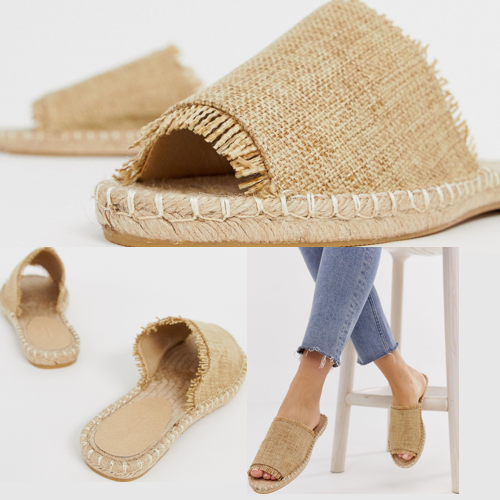

In [206]:
img_size = 500
imgs[1].thumbnail((img_size,img_size))
bgc = cropped.getpixel((cropped.size[0]-1,cropped.size[1]-1))
print('bgc',bgc)
bg = Image.new('RGB',(img_size,img_size),bgc)
bg.paste( imgs[1],(0,0) )

x,y =0,0

if imgs[1].size[0] != img_size : x = imgs[1].size[0]
if imgs[1].size[1] != img_size : y = imgs[1].size[1]

print('x,y',x,y)

img_space = y if x < y else x
print('img_space',img_space)
imgs[2].thumbnail((img_space,img_space))

if x != 0 :x = 500 - x 
if y != 0 :y = 500 - y

print('x,y',x,y)
bg.paste(imgs[2],(x,y))


print('imgs[2]',imgs[2].size)

if x == 0 : x = imgs[2].size[0]
if y == 0 : y = imgs[2].size[1]
print('x,y',x,y)

sx = 500 - x
sy = 500 - y

print('xs,xy',sx,sy)

imgs[0].thumbnail((sx,sy))
bg.paste(imgs[0],(x,y))

bg


In [191]:
imgs[1].size

(500, 253)